In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [241]:
train = pd.read_csv('/Users/luyi/Downloads/Python_aribnb_project/train.csv')

In [62]:
df = pd.read_csv('/Users/luyi/Downloads/Python_aribnb_project/train.csv')

In [242]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

# 1 Data description: Price for 6 major cities

### The house sold in the dateset are from six major cities. 

In [64]:
df.groupby('city').size()

city
Boston      3468
Chicago     3719
DC          5688
LA         22453
NYC        32349
SF          6434
dtype: int64

In [65]:
df['price'] = e**df['log_price']

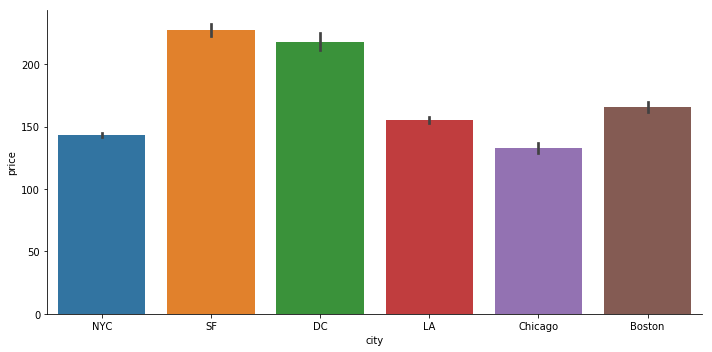

In [66]:
sns.catplot(data=df,y='price',
        kind ='bar',aspect=2, x='city')

#### Boston: high price around 42.35 N, 71 W. It is government center and near downtown 

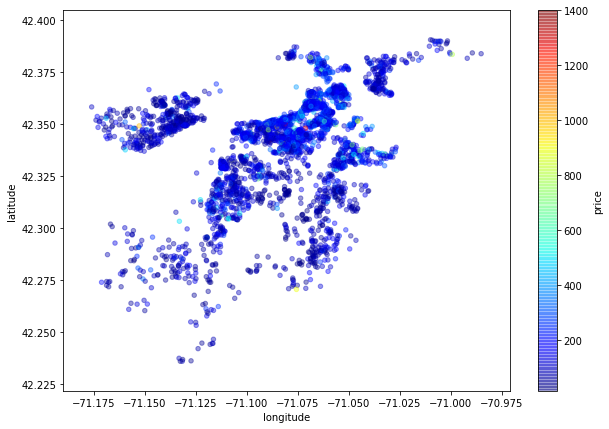

In [100]:
df[df.city == 'Boston'].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
                             c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.savefig('map2.png')

#### Chicago: high price around 41.9 N, 87.67 W. It is west town.

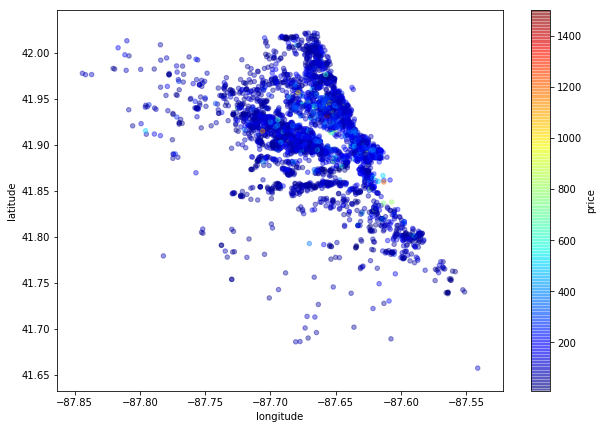

In [101]:
df[df.city == 'Chicago'].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
                             c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.savefig('map2.png')

#### DC: high price separately

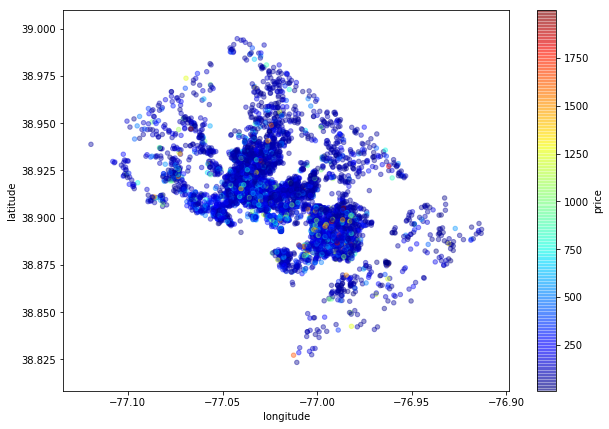

In [102]:
df[df.city == 'DC'].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
                             c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.savefig('map2.png')

#### LA: high price around 34N - 34.2N, santa monica, near sea.

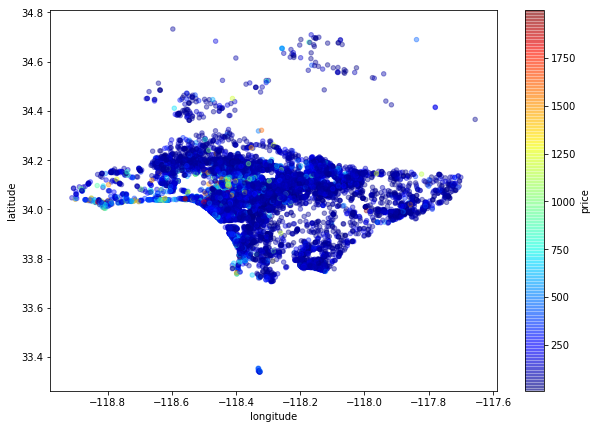

In [103]:
df[df.city == 'LA'].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
                             c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.savefig('map2.png')

#### NYC: high price around Manhattan downtown.

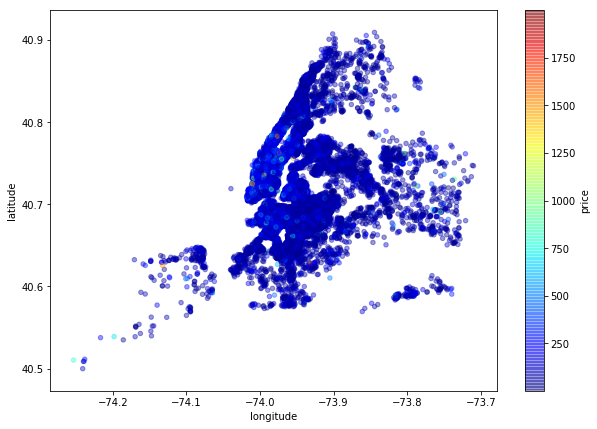

In [104]:
df[df.city == 'NYC'].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
                             c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.savefig('map2.png')

#### SF: high price around the north area.

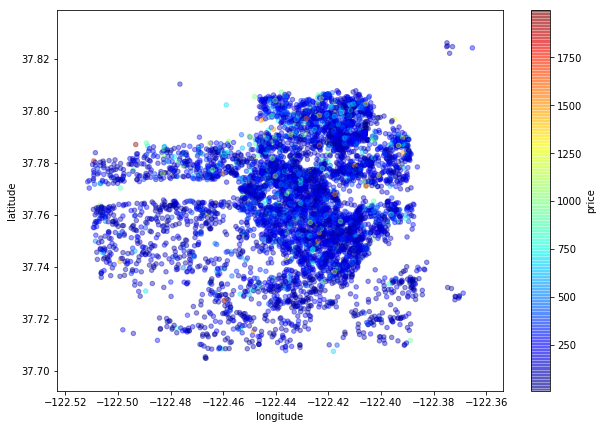

In [105]:
df[df.city == 'SF'].plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), \
                             c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.savefig('map2.png')

# 2 Data Cleaning

### 2.1 Deal with null values

In [72]:
train.isna().sum() 

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64

Drop columns of few influences with price: 'id', 'bed_type', 'host_response_rate', 'name', 'zipcode'. 

Drop columns containing similar information and num values: 'host_since', 'first_review', 'last_review', keep 'number_of_reviews'

In [73]:
train.drop(columns=['id','bed_type',"first_review",'last_review','host_since',\
                    'host_response_rate','name','zipcode'],inplace=True)

Fill the null value of 'review_scores_rating' with average

In [74]:
train["review_scores_rating"] = train["review_scores_rating"].fillna(value = train.review_scores_rating.mean())

Drop the null value of following variables.

In [75]:
train = train.dropna(subset=['neighbourhood','bathrooms','host_has_profile_pic','host_identity_verified','beds','bedrooms'])

### 2.2 Change data type for ML building

Get the number of amenities as new value for 'amentities'

In [76]:
train.amenities=train.amenities.apply(lambda x:(len(str(x).split(','))))

Links showing the pictures of house, so we think customers would like to choose those houses with more description info. Get dummy variable of thumbnail_url has link = 1, or else 0

In [77]:
train.thumbnail_url = ~train.thumbnail_url.isna() *1     

### 2.3 Create new variables from raw data 

count the number of positive words of description_sentiment as new value

In [78]:
positive = open("positive-words.txt")
positive_set = set()
while 1:
    word = positive.readline().strip("\n") 
    if not word:
        break 
    positive_set.add(word)
sentiment_list = []
for s in train.description:
    sentiment = 0
    for word in s.strip('*-()\"#/@;:<>{}`+=~|.!?,$%&').lower().split():
        if word in positive_set:
            sentiment += 1
    sentiment_list.append(sentiment)
train['description_sentiment'] = sentiment_list

In [79]:
train.drop(columns=['description'],inplace = True)

Count the distance with downtown center using latitude and longitude of house 

In [80]:
def lat_center(row):
    if (row['city']=='NYC'):
        return (row['latitude']-40.72)**2+(row['longitude']+74)**2
    elif (row['city']=='LA'):
        return (row['latitude']-34.05)**2+(row['longitude']+118.24)**2
    elif (row['city']=='Boston'):
        return (row['latitude']-42.36)**2+(row['longitude']+71.06)**2
    elif (row['city']=='Chicago'):
        return (row['latitude']-41.88)**2+(row['longitude']+87.62)**2
    elif (row['city']=='DC'):
        return (row['latitude']-38.9)**2+(row['longitude']+77.04)**2
    elif (row['city']=='SF'):
        return (row['latitude']-37.79)**2+(row['longitude']+122.40)**2
train['distance_center'] = train.apply(lambda row:lat_center(row),axis=1)

In [81]:
train.drop(columns=['latitude','longitude'],inplace = True)

In [82]:
train.isna().sum()

log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
instant_bookable          0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
bedrooms                  0
beds                      0
description_sentiment     0
distance_center           0
dtype: int64

In [83]:
train['cleaning_fee'] = train.cleaning_fee + 0

In [84]:
train = train.replace({'t':1,'f':0})

In [85]:
train['cancellation_policy']= train.cancellation_policy.apply(lambda x: 'strict' if x == 'super_strict_60' \
                                                              else 'strict' if x == 'super_strict_30' else x)

In [86]:
train.property_type = train.property_type.apply(lambda x: 'Other' \
                                               if (x!= "Apartment") & (x!= "House") else x)

In [87]:
train = pd.get_dummies(train,columns=['property_type','room_type','cancellation_policy','city'])

### 2.4 Check type and number of each variables we use

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66735 entries, 0 to 74110
Data columns (total 31 columns):
log_price                       66735 non-null float64
amenities                       66735 non-null int64
accommodates                    66735 non-null int64
bathrooms                       66735 non-null float64
cleaning_fee                    66735 non-null int64
host_has_profile_pic            66735 non-null int64
host_identity_verified          66735 non-null int64
instant_bookable                66735 non-null int64
neighbourhood                   66735 non-null object
number_of_reviews               66735 non-null int64
review_scores_rating            66735 non-null float64
thumbnail_url                   66735 non-null int64
bedrooms                        66735 non-null float64
beds                            66735 non-null float64
description_sentiment           66735 non-null int64
distance_center                 66735 non-null float64
property_type_Apartment       

# 3 Classification: Decision Tree

In [243]:
train.median()

id                      1.225415e+07
log_price               4.709530e+00
accommodates            2.000000e+00
bathrooms               1.000000e+00
cleaning_fee            1.000000e+00
latitude                4.066214e+01
longitude              -7.699696e+01
number_of_reviews       6.000000e+00
review_scores_rating    9.600000e+01
bedrooms                1.000000e+00
beds                    1.000000e+00
dtype: float64

In [89]:
train.drop(columns=['neighbourhood'],inplace = True)

In [90]:
train['high_price'] = (train.log_price >= 4.7) * 1.0

In [170]:
import scipy

In [171]:
X = train.drop(columns=['high_price','log_price'])

In [172]:
Y = train.high_price

In [173]:
dt = tree.DecisionTreeClassifier(max_depth = 3)

In [174]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 3.1 Data Visualization with Seaborn (six cities combined)

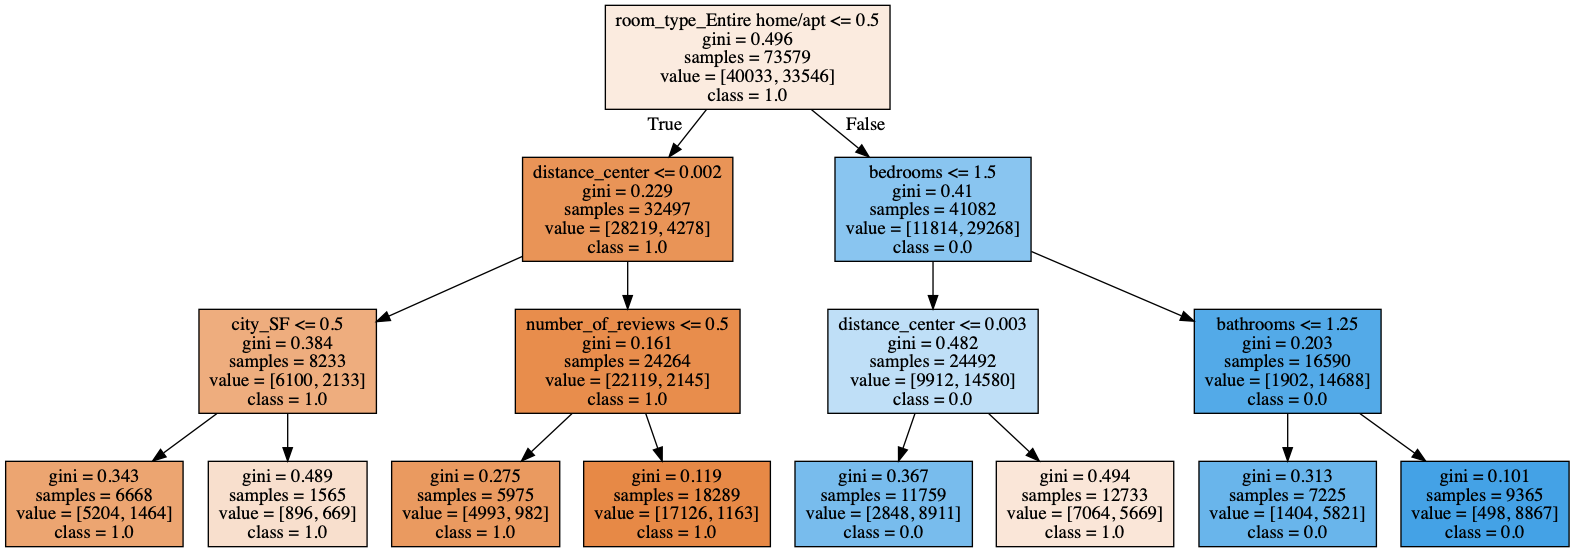

In [175]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [95]:
import seaborn as sns
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [238]:
df.price = e**train.log_price

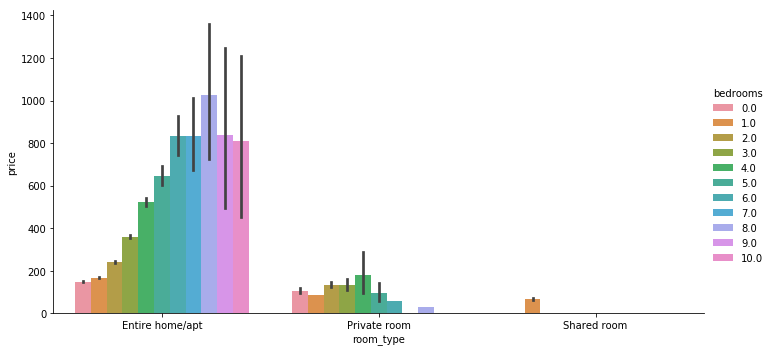

In [244]:
sns.catplot(data=df,y='price', hue='bedrooms',
        kind ='bar',aspect=2, x='room_type')

#### For entrie home/apartment, price increases as bedrooms increase. But the room with zero,one,two,three bedrooms is more expensive for private room.


In [ ]:
sns.catplot(data=train,y='price', hue = 'city',
        kind ='bar',aspect=2, x='cancellation_policy')

#### Entire home/apt tend to have more strict cancellation policy. 
#### Private room and shared room are more expensive with flexible cancellation policy.

In [126]:
train['price'] = e**train['log_price']

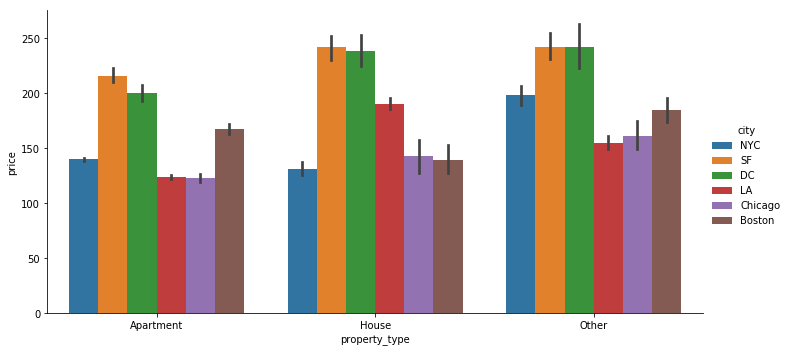

In [129]:
sns.catplot(data=train,y='price', hue = 'city',
        kind ='bar',aspect=2, x='property_type')

#### In six major cities we researched, house tend to be more expensive than apartment in most cities like SF, DC, LA and Chicago, but for NYC and Boston, apartment is more expensive than house.

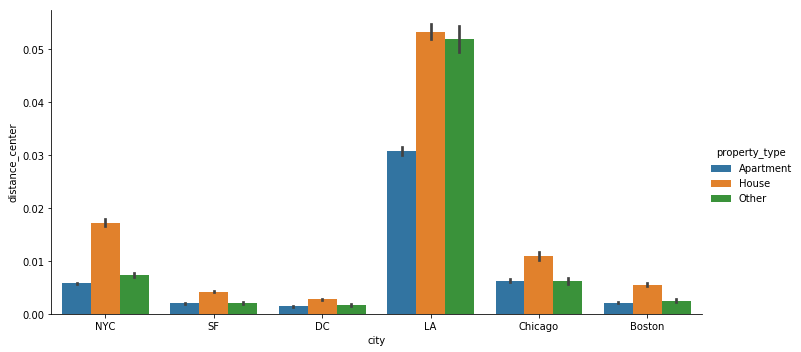

In [145]:
sns.catplot(data=train,y='distance_center', hue = 'property_type',
        kind ='bar',aspect=2, x='city')

#### Houses tend to be far away from city center, by contrast, apartments are closer to city center regarding latitude and longitude.

## 3.2 Seperate different cities:
### LA

In [4]:
df3 = pd.read_csv('train.csv')
df3 = df3[df3.city == 'LA']
df3.drop(columns=['id',"first_review",'last_review',"host_since",'host_response_rate',"name",'zipcode'],inplace=True)
df3["review_scores_rating"] = df3["review_scores_rating"].fillna(value = df3.review_scores_rating.mean())
df3 = df3.dropna(subset=['bathrooms','host_has_profile_pic','host_identity_verified','beds','bedrooms'])
df3.amenities=df3.amenities.apply(lambda x:(len(str(x).split(','))))
df3.thumbnail_url = ~df3.thumbnail_url.isna() *1     #Get dummy variable: has link = 1, or else 0
positive = open("positive-words.txt")
positive_set = set()
while 1:
    word = positive.readline().strip("\n") 
    if not word:
        break 
    positive_set.add(word)
sentiment_list = []
for s in df3.description:
    sentiment = 0
    for word in s.strip('*-()\"#/@;:<>{}`+=~|.!?,$%&').lower().split():
        if word in positive_set:
            sentiment += 1
    sentiment_list.append(sentiment)
df3['description_sentiment'] = sentiment_list
df3.drop(columns=['description'],inplace = True)
def lat_center(row):
    if (row['city']=='LA'):
        return (row['latitude']-40.72)**2+(row['longitude']+73.94)**2
df3['distance_center'] = df3.apply(lambda row:lat_center(row),axis=1)
df3.drop(columns=['latitude','longitude'],inplace = True)
df3['cleaning_fee'] = df3.cleaning_fee*1
df3= df3.replace({'t':1,'f':0})
df3 = pd.get_dummies(df3,columns=['cancellation_policy','city','bed_type','neighbourhood'])
df3 = pd.get_dummies(df3,columns=['property_type'])
df3 = pd.get_dummies(df3,columns=['room_type'])
df3['log_price'] = (df3.log_price >= 4.7) * 1.0

In [5]:
import scipy
X = df3.drop(columns='log_price')
Y = df3.log_price
dt3 = tree.DecisionTreeClassifier(max_depth =3 )
dt3.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

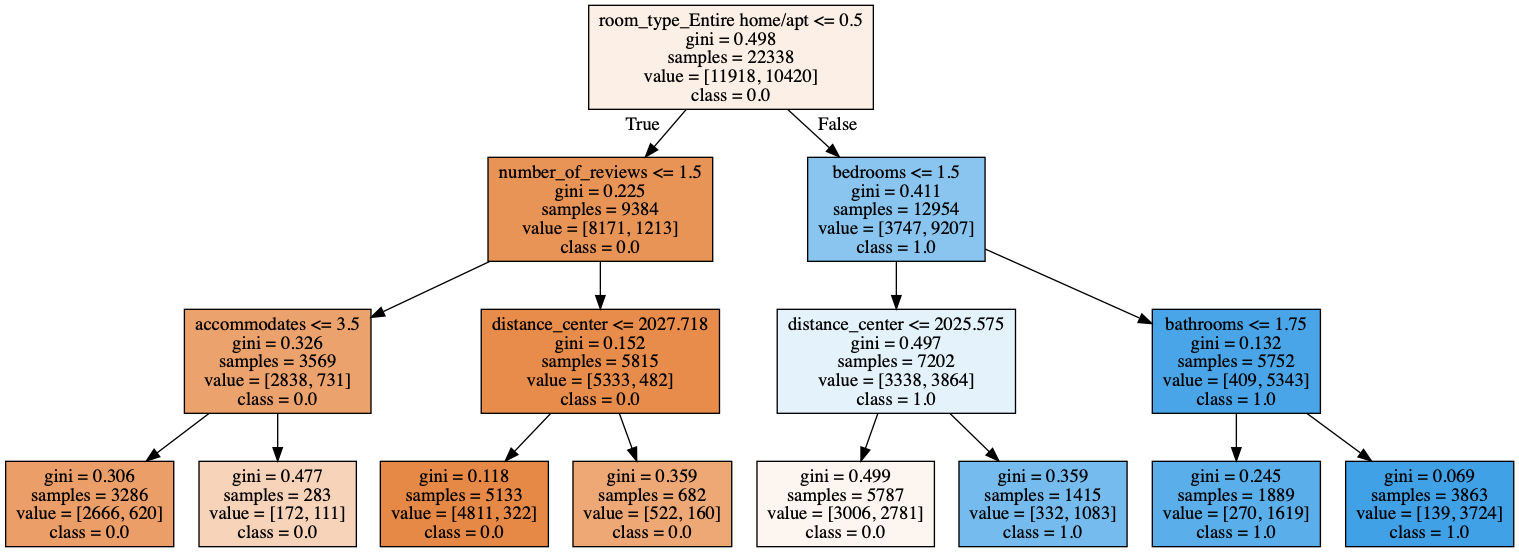

In [6]:
dt3_feature_names = list(X.columns)
dt3_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt3, out_file='tree.dot', 
    feature_names=dt3_feature_names, class_names=dt3_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

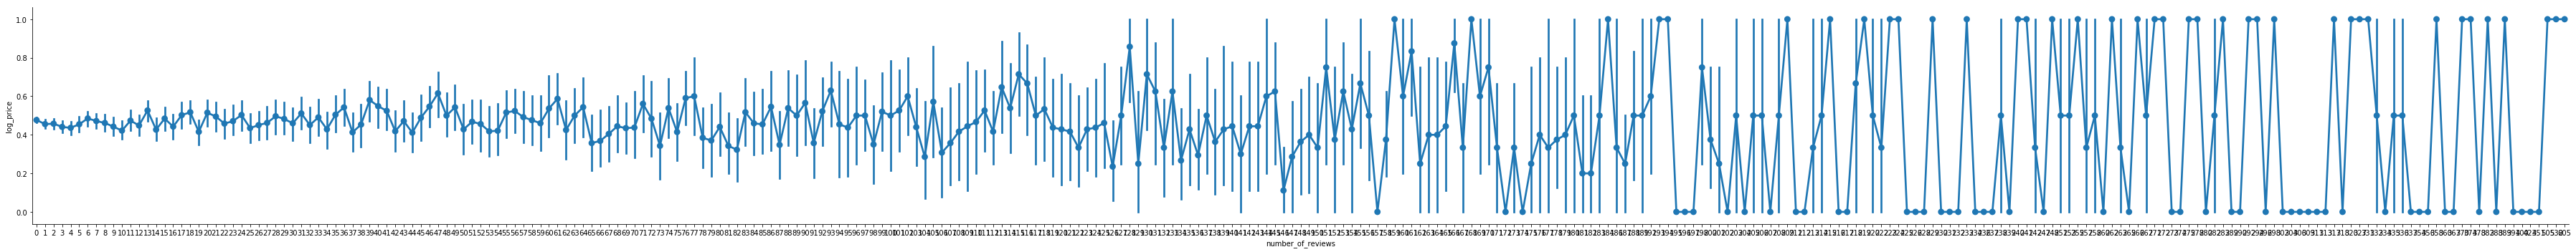

In [10]:
sns.catplot(data=df3,x='number_of_reviews',y='log_price',kind='point',aspect=10)

### NYC

In [12]:
df4 = pd.read_csv('train.csv')
df4 = df4[df4.city == 'NYC']

In [11]:
df2.T

,0,1,2,10,18,19,21,25,27,29,...,74090,74091,74094,74095,74096,74097,74100,74106,74108,74109
log_price,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
amenities,9.000000,15.000000,19.000000,15.000000,18.000000,24.000000,11.000000,44.000000,21.000000,18.000000,...,21.000000,8.000000,15.000000,9.000000,16.000000,16.000000,23.000000,1.000000,31.000000,15.000000
accommodates,3.000000,7.000000,5.000000,2.000000,2.000000,8.000000,2.000000,6.000000,4.000000,3.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,5.000000,2.000000
bathrooms,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
cleaning_fee,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
host_has_profile_pic,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
host_identity_verified,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
instant_bookable,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
number_of_reviews,2.000000,6.000000,10.000000,82.000000,26.000000,5.000000,57.000000,14.000000,4.000000,40.000000,...,16.000000,5.000000,7.000000,0.000000,2.000000,31.000000,32.000000,0.000000,43.000000,0.000000
review_scores_rating,100.000000,93.000000,92.000000,93.000000,86.000000,72.000000,89.000000,100.000000,100.000000,88.000000,...,100.000000,100.000000,86.000000,93.506553,60.000000,92.000000,93.000000,93.506553,94.000000,93.506553


In [7]:
df2 = pd.read_csv('train.csv')
df2 = df2[df2.city == 'NYC']
df2.drop(columns=['id',"first_review",'last_review',"host_since",'host_response_rate',"name",'zipcode'],inplace=True)
df2["review_scores_rating"] = df2["review_scores_rating"].fillna(value = df2.review_scores_rating.mean())
df2 = df2.dropna(subset=['bathrooms','host_has_profile_pic','host_identity_verified','beds','bedrooms'])
df2.amenities=df2.amenities.apply(lambda x:(len(str(x).split(','))))
df2.thumbnail_url = ~df2.thumbnail_url.isna() *1     #Get dummy variable: has link = 1, or else 0
positive = open("positive-words.txt")
positive_set = set()
while 1:
    word = positive.readline().strip("\n") 
    if not word:
        break 
    positive_set.add(word)
sentiment_list = []
for s in df2.description:
    sentiment = 0
    for word in s.strip('*-()\"#/@;:<>{}`+=~|.!?,$%&').lower().split():
        if word in positive_set:
            sentiment += 1
    sentiment_list.append(sentiment)
df2['description_sentiment'] = sentiment_list
df2.drop(columns=['description'],inplace = True)
def lat_center(row):
    if (row['city']=='NYC'):
        return (row['latitude']-40.72)**2+(row['longitude']+73.94)**2
df2['distance_center'] = df2.apply(lambda row:lat_center(row),axis=1)
df2.drop(columns=['latitude','longitude'],inplace = True)
df2['cleaning_fee'] = df2.cleaning_fee*1
df2= df2.replace({'t':1,'f':0})
df2 = pd.get_dummies(df2,columns=['cancellation_policy','city','bed_type','neighbourhood'])
df2 = pd.get_dummies(df2,columns=['property_type'])
df2 = pd.get_dummies(df2,columns=['room_type'])
df2['log_price'] = (df2.log_price >= 4.7) * 1.0

In [8]:
import scipy
X = df2.drop(columns='log_price')
Y = df2.log_price
dt2 = tree.DecisionTreeClassifier(max_depth =3 )
dt2.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

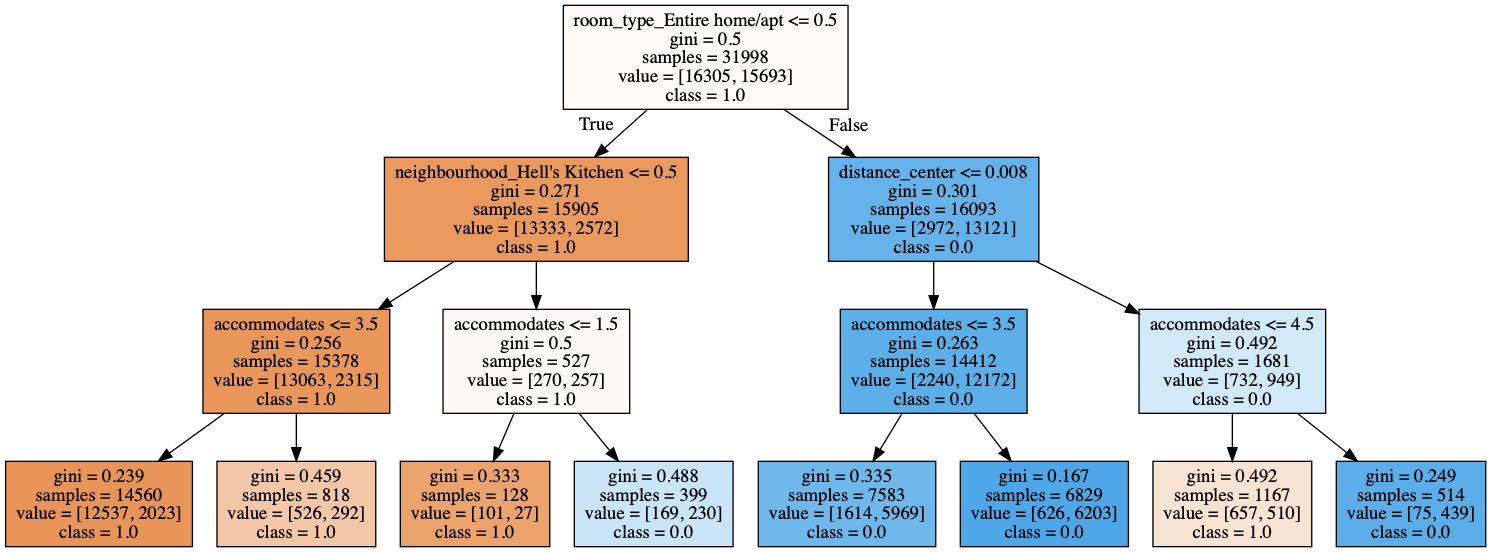

In [10]:
dt2_feature_names = list(X.columns)
dt2_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt2, out_file='tree.dot', 
    feature_names=dt2_feature_names, class_names=dt2_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

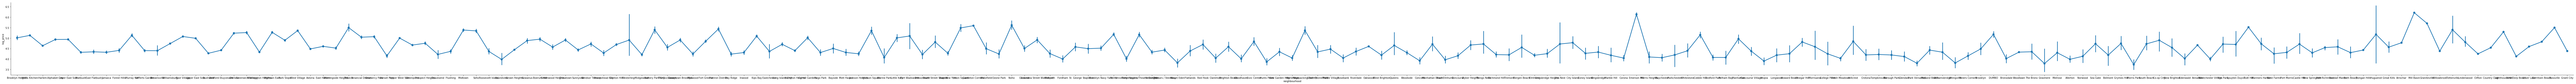

In [16]:
sns.catplot(data=df4,x='neighbourhood',y='log_price',kind='point',aspect=30)

### SF

In [431]:
df.groupby('city').size()

city
Boston      3468
Chicago     3719
DC          5688
LA         22453
NYC        32349
SF          6434
dtype: int64

In [432]:
df = df[df.city == 'SF']

In [433]:
df.corr()

,id,log_price,accommodates,bathrooms,cleaning_fee,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
id,1.000000,0.004250,-0.009254,-0.022338,-0.008866,0.017807,0.037066,0.001490,-0.020905,-0.003603,0.003395
log_price,0.004250,1.000000,0.621799,0.371443,0.027140,0.205150,0.050748,-0.150148,0.150012,0.542065,0.524205
accommodates,-0.009254,0.621799,1.000000,0.466892,0.136042,-0.035712,-0.069051,-0.058244,0.035888,0.733814,0.805886
bathrooms,-0.022338,0.371443,0.466892,1.000000,0.053194,-0.033340,-0.042155,-0.081249,0.024010,0.558900,0.504089
cleaning_fee,-0.008866,0.027140,0.136042,0.053194,1.000000,-0.114142,-0.061135,0.177842,0.023290,0.100154,0.118132
latitude,0.017807,0.205150,-0.035712,-0.033340,-0.114142,1.000000,0.144522,-0.101939,-0.002404,-0.092089,-0.065851
longitude,0.037066,0.050748,-0.069051,-0.042155,-0.061135,0.144522,1.000000,-0.082564,-0.006515,-0.097062,-0.083510
number_of_reviews,0.001490,-0.150148,-0.058244,-0.081249,0.177842,-0.101939,-0.082564,1.000000,0.030607,-0.099126,-0.064767
review_scores_rating,-0.020905,0.150012,0.035888,0.024010,0.023290,-0.002404,-0.006515,0.030607,1.000000,0.068619,0.032331
bedrooms,-0.003603,0.542065,0.733814,0.558900,0.100154,-0.092089,-0.097062,-0.099126,0.068619,1.000000,0.752682


In [397]:
df.T

,6,7,9,11,12,14,20,22,23,26,...,74081,74087,74089,74098,74099,74101,74102,74105,74107,74110
id,11825529,13971273,5385260,17423675,14066228,583490,7264511,3563677,17615783,19407360,...,13996915,15042259,4550722,8342838,4615631,18077717,7935934,808802,13281809,3534845
log_price,4.41884,4.78749,3.58352,5.01064,4.2485,4.95583,4.38203,4.90527,4.00733,4.55388,...,6.90776,4.47734,4.60517,4.55388,4.27667,4.58497,4.11087,4.2485,5.04343,4.85203
property_type,Apartment,Condominium,House,House,Apartment,Apartment,House,Apartment,House,Apartment,...,Other,Apartment,House,Apartment,Condominium,Apartment,Villa,House,Apartment,Boat
room_type,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Private room,Entire home/apt,Private room,Entire home/apt,Private room,Entire home/apt,...,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Shared room,Private room,Entire home/apt,Entire home/apt
amenities,"{TV,Internet,""Wireless Internet"",""Air conditio...","{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...","{""Wireless Internet"",""Air conditioning"",Kitche...","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{TV,Internet,""Wireless Internet"",Kitchen,""Free...","{Kitchen,Heating,""Smoke detector"",""Carbon mono...","{""Cable TV"",Internet,""Wireless Internet"",""Air ...","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","{Internet,""Wireless Internet"",""Air conditionin...","{TV,""Wireless Internet"",Pool,Kitchen,""Elevator...",...,"{TV,""Wireless Internet"",""Air conditioning"",Kit...","{TV,""Wireless Internet"",""Air conditioning"",Poo...","{TV,""Cable TV"",Internet,""Air conditioning"",Poo...","{Internet,""Wireless Internet"",""Air conditionin...","{TV,Internet,""Wireless Internet"",""Air conditio...","{TV,Internet,""Wireless Internet"",Pool,Kitchen,...","{TV,""Wireless Internet"",""Air conditioning"",Kit...","{TV,Internet,""Wireless Internet"",""Air conditio...","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
accommodates,3,2,2,4,2,2,2,4,2,2,...,16,4,2,4,2,1,10,2,4,4
bathrooms,1,1,1,1.5,1,1,1,1,1,1,...,1,1,1,1,1,1,3,1,2,1
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,...,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,moderate,moderate,moderate,strict,flexible,strict,strict,moderate,moderate,flexible,...,moderate,strict,strict,flexible,moderate,moderate,flexible,moderate,moderate,moderate
cleaning_fee,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,False,True,True,False


In [434]:
df.drop(columns=['id',"first_review",'last_review',"host_since",'host_response_rate',"name",'zipcode'],inplace=True)
df["review_scores_rating"] = df["review_scores_rating"].fillna(value = df.review_scores_rating.mean())
df = df.dropna(subset=['bathrooms','host_has_profile_pic','host_identity_verified','beds','bedrooms'])

In [435]:
df.amenities=df.amenities.apply(lambda x:(len(str(x).split(','))))

In [436]:
df.thumbnail_url = ~df.thumbnail_url.isna() *1     #Get dummy variable: has link = 1, or else 0

In [437]:
positive = open("positive-words.txt")
positive_set = set()
while 1:
    word = positive.readline().strip("\n") 
    if not word:
        break 
    positive_set.add(word)
sentiment_list = []
for s in df.description:
    sentiment = 0
    for word in s.strip('*-()\"#/@;:<>{}`+=~|.!?,$%&').lower().split():
        if word in positive_set:
            sentiment += 1
    sentiment_list.append(sentiment)
df['description_sentiment'] = sentiment_list

In [438]:
df.drop(columns=['description'],inplace = True)

In [439]:
def lat_center(row):
    if (row['city']=='SF'):
        return (row['latitude']-37.77)**2+(row['longitude']+122.43)**2
df['distance_center'] = df.apply(lambda row:lat_center(row),axis=1)
df.drop(columns=['latitude','longitude'],inplace = True)

In [440]:
df['cleaning_fee'] = df.cleaning_fee*1
df= df.replace({'t':1,'f':0})

In [441]:
df = pd.get_dummies(df,columns=['cancellation_policy','city','bed_type','neighbourhood'])

In [442]:
df = pd.get_dummies(df,columns=['property_type'])

In [443]:
df = pd.get_dummies(df,columns=['room_type'])

In [444]:
df['log_price'] = (df.log_price >= 4.6) * 1.0

In [445]:
import scipy
X = df.drop(columns='log_price')
Y = df.log_price
dt = tree.DecisionTreeClassifier(max_depth =3 )
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

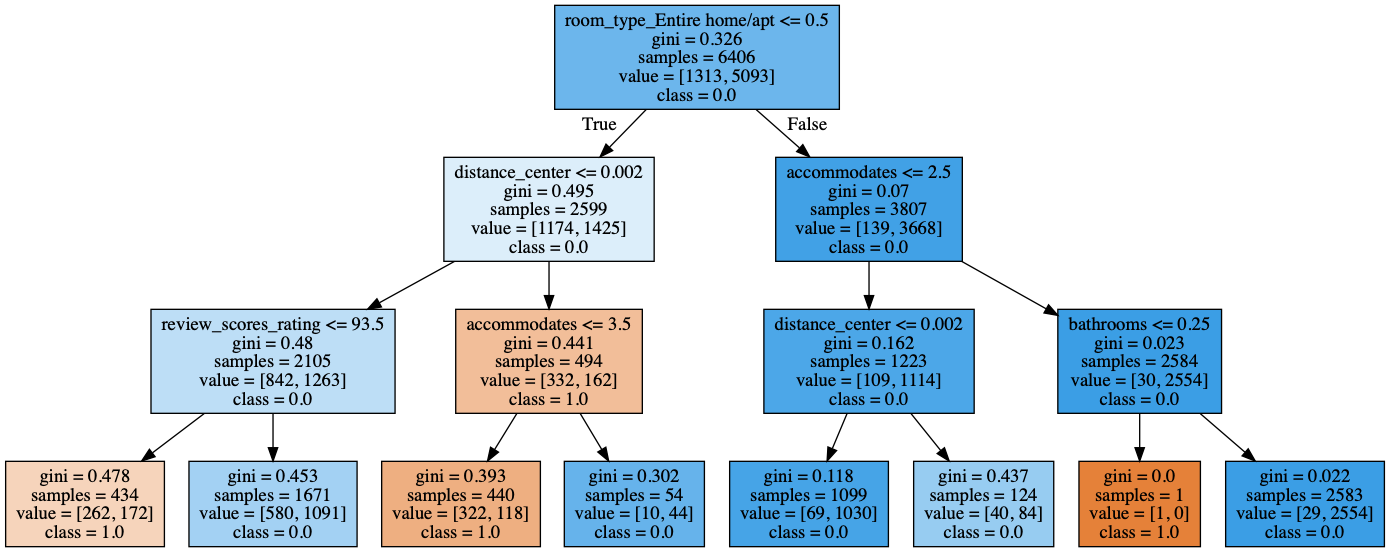

In [446]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

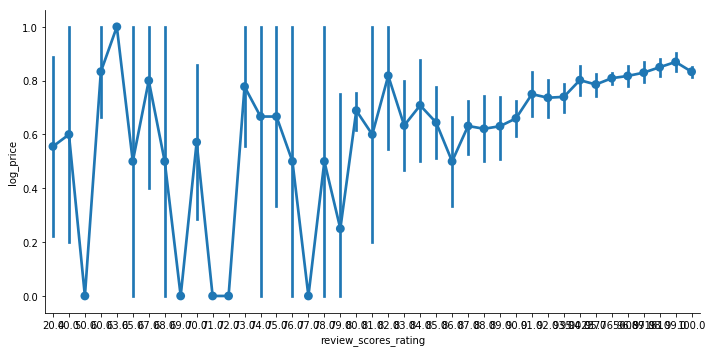

In [452]:

sns.catplot(data=df,x='review_scores_rating',y='log_price',kind='point',aspect=2)


In [3]:
sns.catplot(data=df,x='accomodates',y='log_price',kind='point',aspect=2)

NameError: name 'df' is not defined

# 4 Clustering

In [180]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

In [186]:
df2 = train.copy()
df2 = (df2 - df2.mean() ) / df2.std()
clu = KMeans(n_clusters=3,random_state=0)
clu.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [187]:
df3 = train.copy()
df3['cluster'] = clu.labels_

In [188]:
df3.groupby('cluster').size()

cluster
0    16192
1     5774
2     6738
dtype: int64

In [189]:
df3.groupby('cluster').mean().T

cluster,0,1,2
log_price,0.629076,0.907516,0.614574
amenities,17.888649,22.034465,14.959780
accommodates,2.977396,6.158469,2.974176
bathrooms,1.015656,1.638639,1.069308
cleaning_fee,0.866663,0.917735,0.555209
host_has_profile_pic,0.997838,0.998614,0.993618
host_identity_verified,0.731781,0.726013,0.569012
instant_bookable,0.227334,0.356599,0.232562
number_of_reviews,24.530262,26.987877,6.901454
review_scores_rating,94.087455,93.331528,93.978954


# 5 Remove room type
#### We drop the columns about room type  to build another decision tree since it is too obvious that the price of entire apartment/house is higher than that of a single room.

In [178]:
X = train.drop(columns=['high_price','log_price','room_type_Entire home/apt',\
                        'room_type_Private room','room_type_Shared room'])

In [179]:
Y = train.high_price

In [180]:
dt = tree.DecisionTreeClassifier(max_depth = 3)

In [181]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

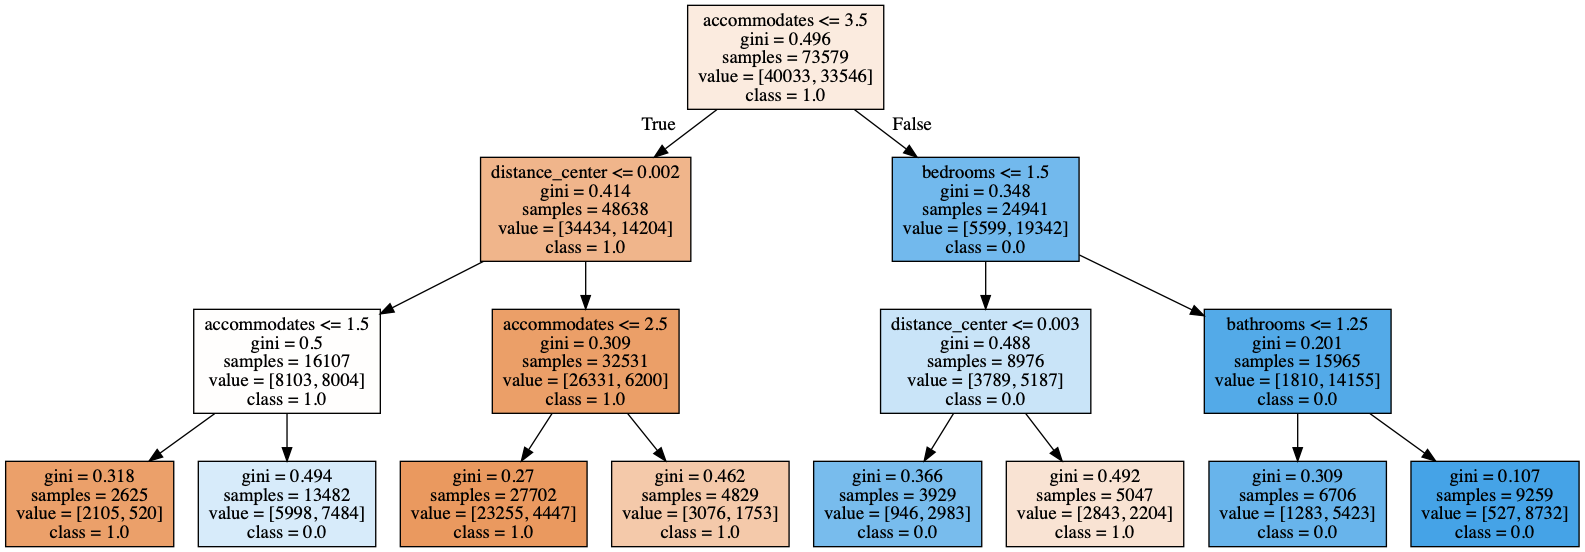

In [182]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

# 6 Linear Regression : Prediction of price range

In [109]:
data_train = pd.read_csv('/Users/luyi/Downloads/Python_aribnb_project/train.csv')

In [110]:
data_test = pd.read_csv('/Users/luyi/Downloads/Python_aribnb_project/test.csv')

In [111]:
print("\nThe train data size is : {} ".format(data_train.shape))
print("The test data size is : {} ".format(data_test.shape))


The train data size is : (74111, 29) 
The test data size is : (25458, 28) 


## Appendix : before regression

#### Dependent variable Log_price is normal distribution

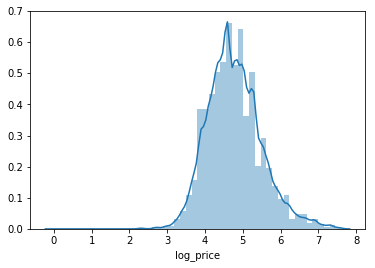

In [123]:
import matplotlib.pyplot as plt
sns.distplot(data_train['log_price'])

#### Comparision between the test and train set: no inherent difference between test & train
Because even if we’ve picked the best model some inherent difference between test and train dataset can still make this model performs poorly on test data.

The number ratio in each city in Train set vs Test set seem to be similar.

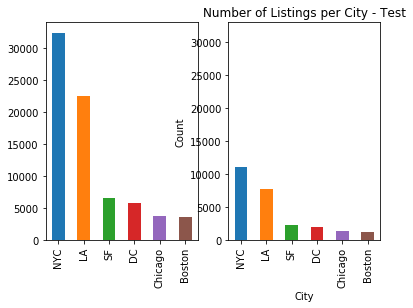

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

data_train['city'].value_counts().plot(kind='bar', ax=ax1)
plt.title('Number of Listings per City - Train')
plt.xlabel('City')
plt.ylabel('Count')


data_test['city'].value_counts().plot(kind='bar', ax=ax2)
plt.title('Number of Listings per City - Test')
plt.xlabel('City')
plt.ylabel('Count')
plt.ylim(0,33000 )
plt.show()

#### how much each independent variable correlates with this dependent variable

In [124]:
corr_mx = data_train.corr()
corr_mx["log_price"].sort_values(ascending=False)

log_price               1.000000
accommodates            0.567574
bedrooms                0.473212
beds                    0.442153
bathrooms               0.355420
cleaning_fee            0.111191
review_scores_rating    0.091219
latitude               -0.002193
id                     -0.007178
number_of_reviews      -0.032470
longitude              -0.047529
Name: log_price, dtype: float64